In [56]:
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [2]:
oppScrData = pd.read_excel (r'sample_data/OppScrData.xlsx')

Utils

In [72]:
def normalize_ss(data):
  return StandardScaler().fit_transform(data)

def normalize_min_max(data):
    n = data.shape[1]    
    for i in range(n-1):
      data[:,i] = (data[:,i] - np.min(data[:,i]))/(np.max(data[:,i])- np.min(data[:,i]))
    return data

def plot(y_pred, y_test):
  plt.figure()
  x = [i+1 for i in range(len(y_test))]
  plt.plot((x,x),([i for i in y_pred], [j for j in y_test]),c='green')
  plt.scatter(x, y_pred, label="predicted_y")
  plt.scatter(x, y_test, label="actual_y")
  plt.legend()
  plt.show()

def mean_absolute_error(actual, predictions):
  n = len(actual)
  return sum(abs(actual - predictions))/n


Get all dead people

In [3]:
def get_dead_people_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[['Age at CT', 'DEATH [d from CT]','Sex', "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)']]
    n = ct_data.shape[0]
    dead_people_ct_data = []

    for i in range(n):
        row = ct_data.loc[i]
        ignore = False
        for j in row:
          if pd.isna(j) or j == ' ': # There is an empty string somewhere in Liver column
            ignore = True
            break          

        if (not ignore) and (not pd.isna(row['DEATH [d from CT]'])):
          row[0] = (row['Age at CT']*365 + row['DEATH [d from CT]']) - ((76.1*365) if row['Sex'] == "Male" else (81.1*365)          )
          dead_people_ct_data.append(row)

    dead_people_ct_data = np.array(dead_people_ct_data)
    dead_people_ct_data = np.delete(dead_people_ct_data, 1, 1)
    dead_people_ct_data = np.delete(dead_people_ct_data, 1, 1)
    return np.array(dead_people_ct_data, dtype=np.float32)

# dead_people_ct_data[0] -> number of days lost
# dead_people_ct_data[1:] -> ct_data


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [ ]:
dead_people_ct_data = get_dead_people_ct_data(oppScrData)

In [58]:
y = dead_people_ct_data[:,0]
# X = normalize_ss(dead_people_ct_data[:,1:])
# X = normalize_min_max(dead_people_ct_data[:,1:])
X = dead_people_ct_data[:,1:]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

Linear

0.08123459530521104


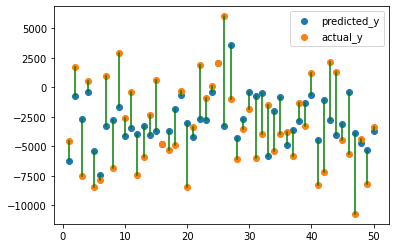

In [61]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(r2_score(y_test, y_pred))
plot(y_test=y_test, y_pred=y_pred)

Polynomial

3378.28181640625


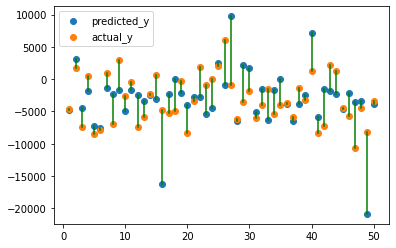

In [79]:
poly = PolynomialFeatures(degree=3, include_bias=True)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.transform(x_test)

#include bias parameter
lr = LinearRegression()
lr.fit(x_train_trans, y_train)
y_pred = lr.predict(x_test_trans)
print(mean_absolute_error(y_test, y_pred))
plot(y_test=y_test, y_pred=y_pred)

Lasso

In [57]:
lr = linear_model.Lasso(alpha=0.1)
lr.fit(x_train_trans, y_train)
y_pred = lr.predict(x_test_trans)
print(r2_score(y_test, y_pred))

-57.823182759894046


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+08, tolerance: 8.119e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
